In [1]:
%matplotlib widget

import os
import numpy as np
import pandas as pd
import itertools as it
from glob import glob
import matplotlib.pyplot as plt
from sbpy.calib import Sun
from astropy import units as u
from astropy.io import fits
from astropy.visualization import simple_norm
from copy import deepcopy as copy

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from astropy.visualization import ImageNormalize, PercentileInterval, AsinhStretch

from lvmdrp.core.constants import LVM_UNAM_URL
from lvmdrp.utils.examples import fetch_example_data, get_frames_metadata, fix_lamps_metadata, get_masters_metadata

from lvmdrp.core import rss, image, spectrum1d
from lvmdrp.functions import imageMethod, rssMethod, fluxCalMethod

plt.style.use("seaborn-v0_8-talk")

In [2]:
# define input data directory
data_path = os.path.abspath(os.path.join("..", "data"))

# let's create the output directory
output_path = "./data"
os.makedirs(output_path, exist_ok=True)

# create processed frames path template
out_main_path = os.path.join(output_path, "lvm-{kind}-{camera}-{expnum}.fits")
out_calib_path = os.path.join(output_path, "lvm-{mjd}-{kind}-{camera}-{exptime}.fits")

In [3]:
# extract metadata
frames_table = get_frames_metadata(path=os.path.join(data_path, "lco_com"), ignore_cache=False).to_pandas()
frames_table = frames_table.loc[~frames_table.mjd.isin([60008,60009,60037,60038])]
# fix arc lamps metadata
fix_lamps_metadata(metadata=frames_table, lamp_names="argon neon ldls hgne xenon krypton".split())

[INFO]: loading cached metadata from '/home/mejia/Research/UNAM/lvm-drp/lvmdrp/examples/data/lco_com/frames_table.pkl'


[INFO]: starting preprocessing of raw image 'sdR-s-z1-00000223.fits.gz'
[INFO]: using header IMAGETYP = 'object'
[WARNING]: assuming TRIMSEC = ['[1:2043, 2041:4080]', '[2078:4120, 2041:4080]', '[1:2043, 1:2040]', '[2078:4120, 1:2040]']
[WARNING]: assuming BIASSEC = ['[2044:2060, 2041:4080]', '[2061:2077, 2041:4080]', '[2044:2060, 1:2040]', '[2061:2077, 1:2040]']
[INFO]: using header GAIN = [2.76, 2.65, 2.89, 2.78] (e-/ADU)
[INFO]: median and standard deviation in OS quadrant 1: 2746.20 +/- 2.98 (e-)
[INFO]: median and standard deviation in OS quadrant 2: 2634.10 +/- 2.94 (e-)
[INFO]: median and standard deviation in OS quadrant 3: 2907.34 +/- 4.32 (e-)
[INFO]: median and standard deviation in OS quadrant 4: 2810.58 +/- 3.29 (e-)
[INFO]: using header RDNOISE = [3.6, 3.6, 3.4, 3.6] (e-)
[INFO]: flipping along X-axis
[INFO]: updating header with per quadrant stats
[INFO]: building pixel mask
[INFO]: 7976 (0.048 %) pixels masked
[INFO]: writing output image to lvm-pbias-z1-00000223.fits
[W

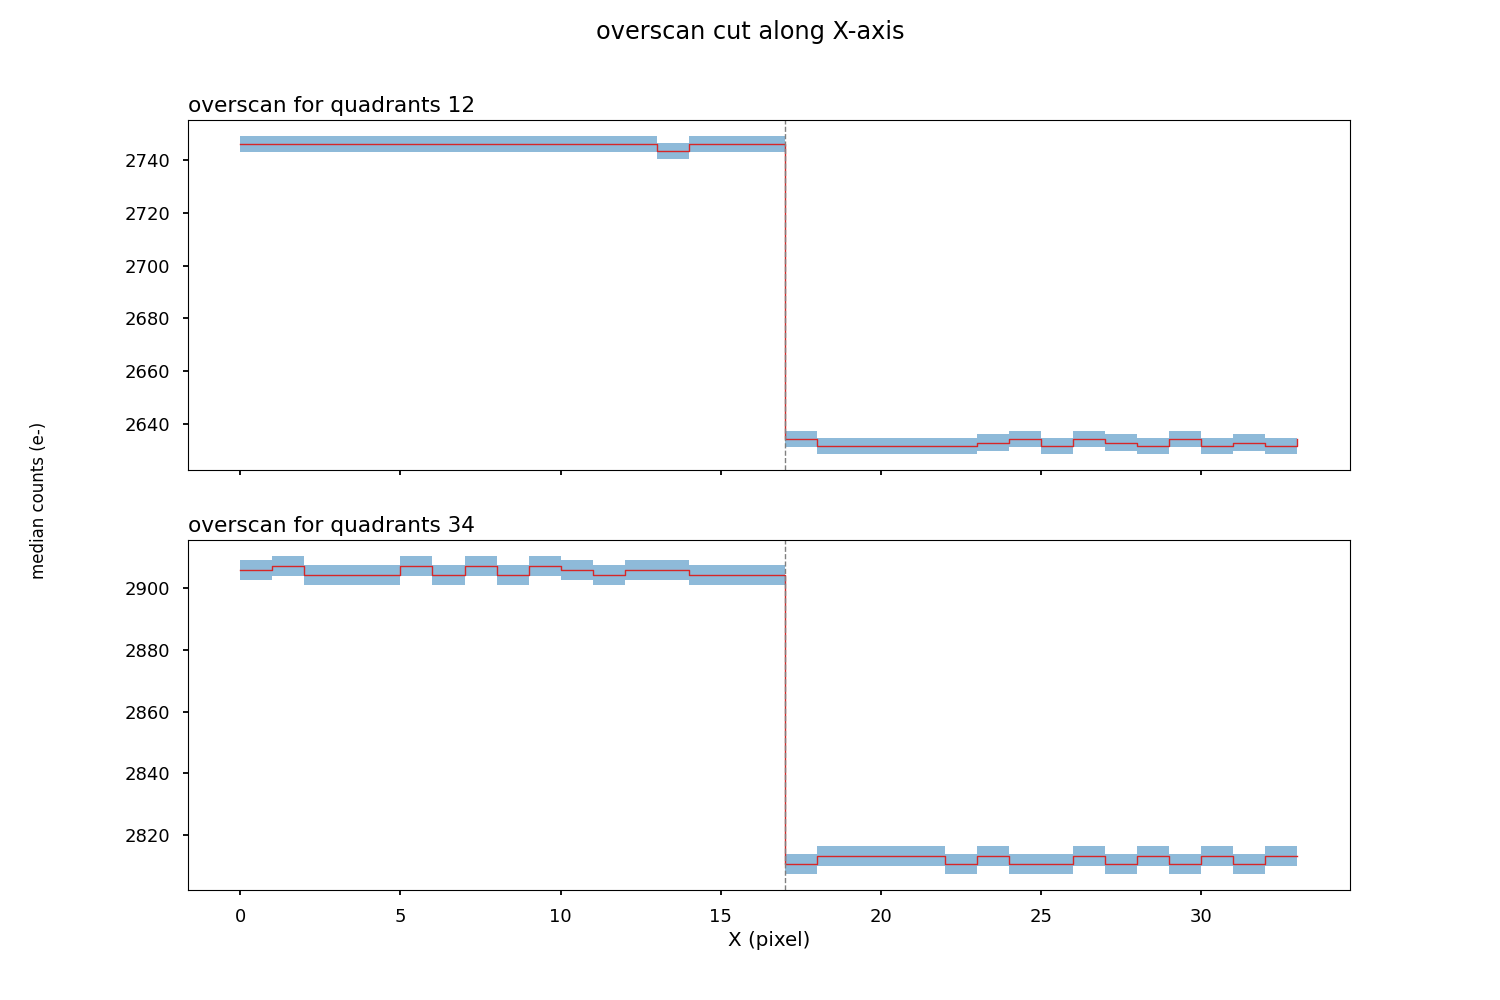

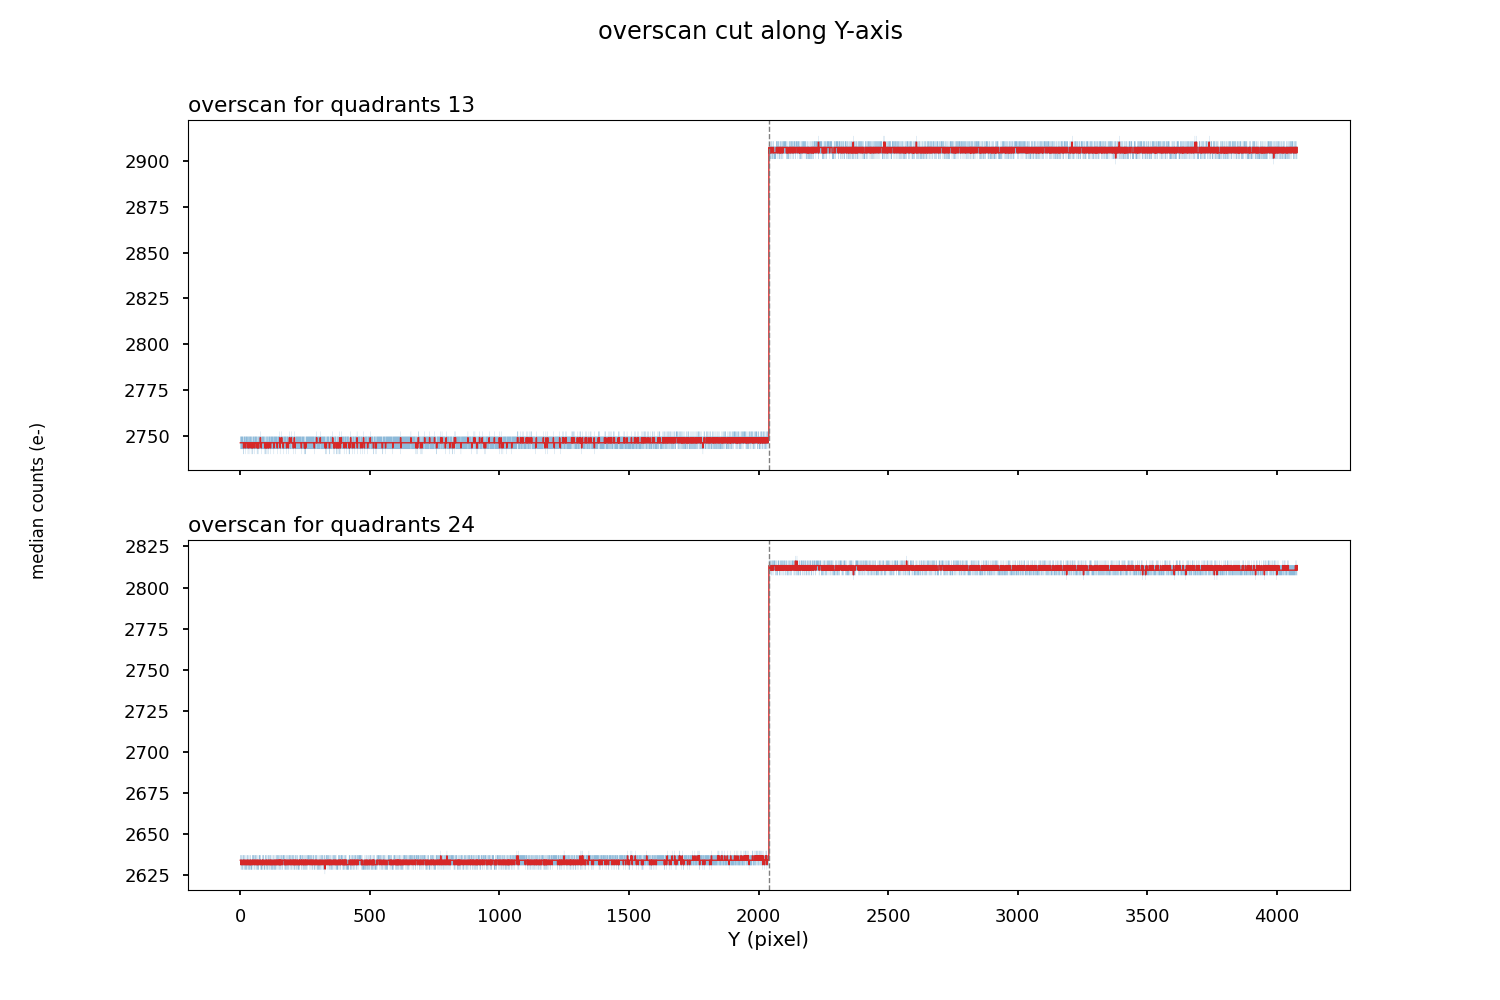

(2040, 17)
(2040, 17)
(2040, 17)
(2040, 17)


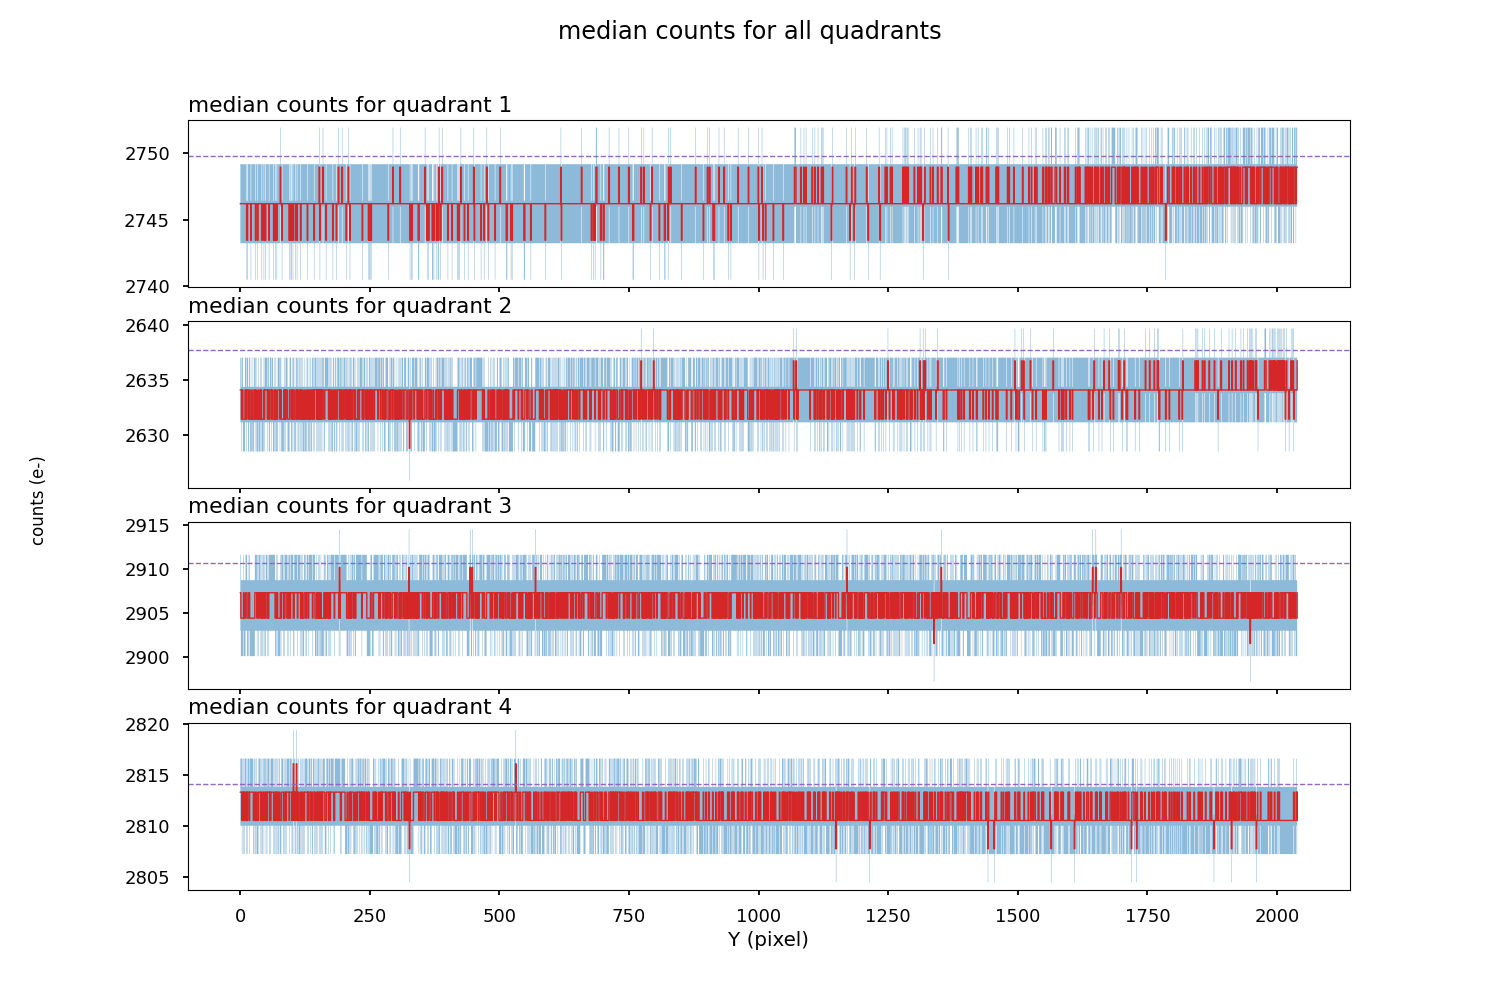

In [4]:
frame = frames_table.query("expnum=='00000223' & camera=='z1'").iloc[0]
frame_path = frame["path"]
frame_camera, frame_expnum = frame["camera"], frame["expnum"]

imageMethod.preprocRawFrame_drp(
    in_image=frame_path,
    out_image=out_main_path.format(kind="pbias", camera=frame_camera, expnum=frame_expnum),
    in_mask=out_calib_path.format(mjd="super", kind="mask", camera=frame_camera, exptime="x"),
    display_plots="1"
)

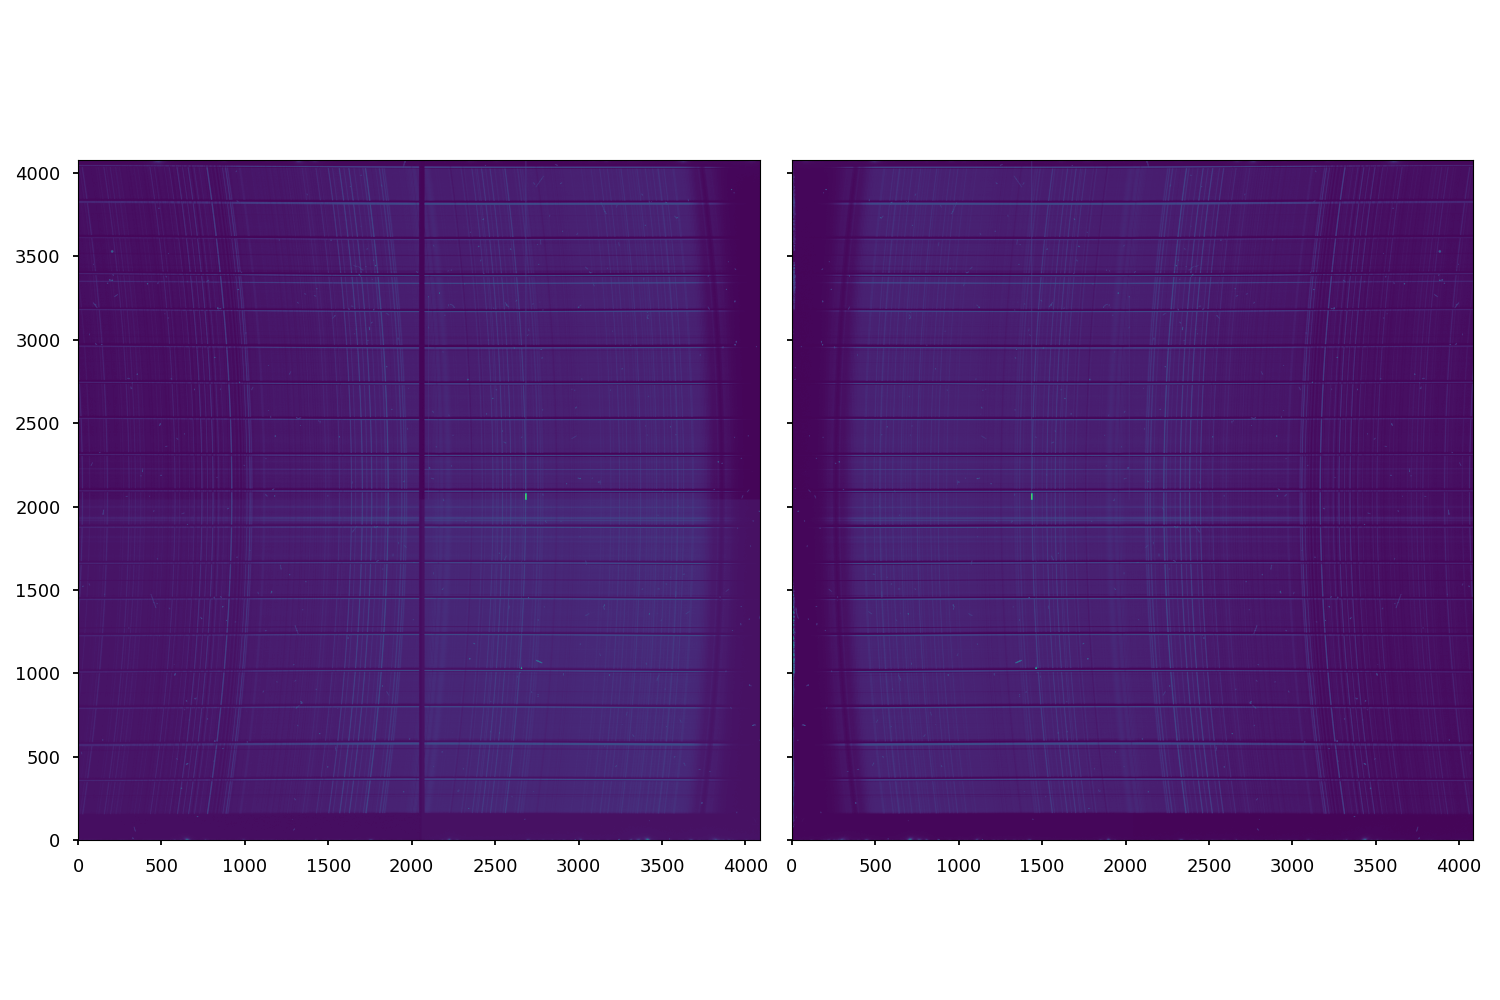

In [5]:
raw = image.loadImage(frame_path)
img = image.loadImage(out_main_path.format(kind="pbias", camera="z1", expnum=frame_expnum))

fig, axs = plt.subplots(1, 2, figsize=(15,10), sharex=True, sharey=True)
norm = simple_norm(raw._data, stretch="log", clip=True)
axs[0].imshow(raw._data, origin="lower", norm=norm)
norm = simple_norm(img._data, stretch="log")
axs[1].imshow(img._data, origin="lower", norm=norm)
fig.tight_layout()

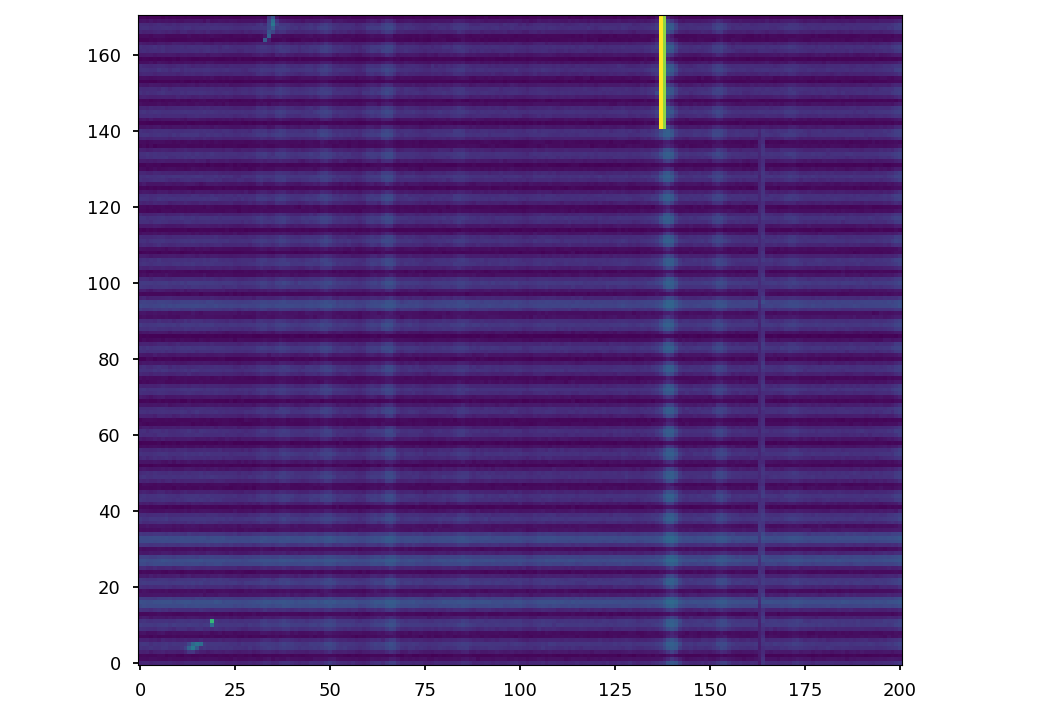

In [6]:
# sub_img = img.getSection("[1300:1400, 1040:1100]")
sub_img = img.getSection("[1300:1500, 1900:2070]")

plt.figure()
norm = simple_norm(sub_img._data, stretch="log", clip=True)
plt.imshow(sub_img._data, origin="lower", norm=norm)
plt.tight_layout()

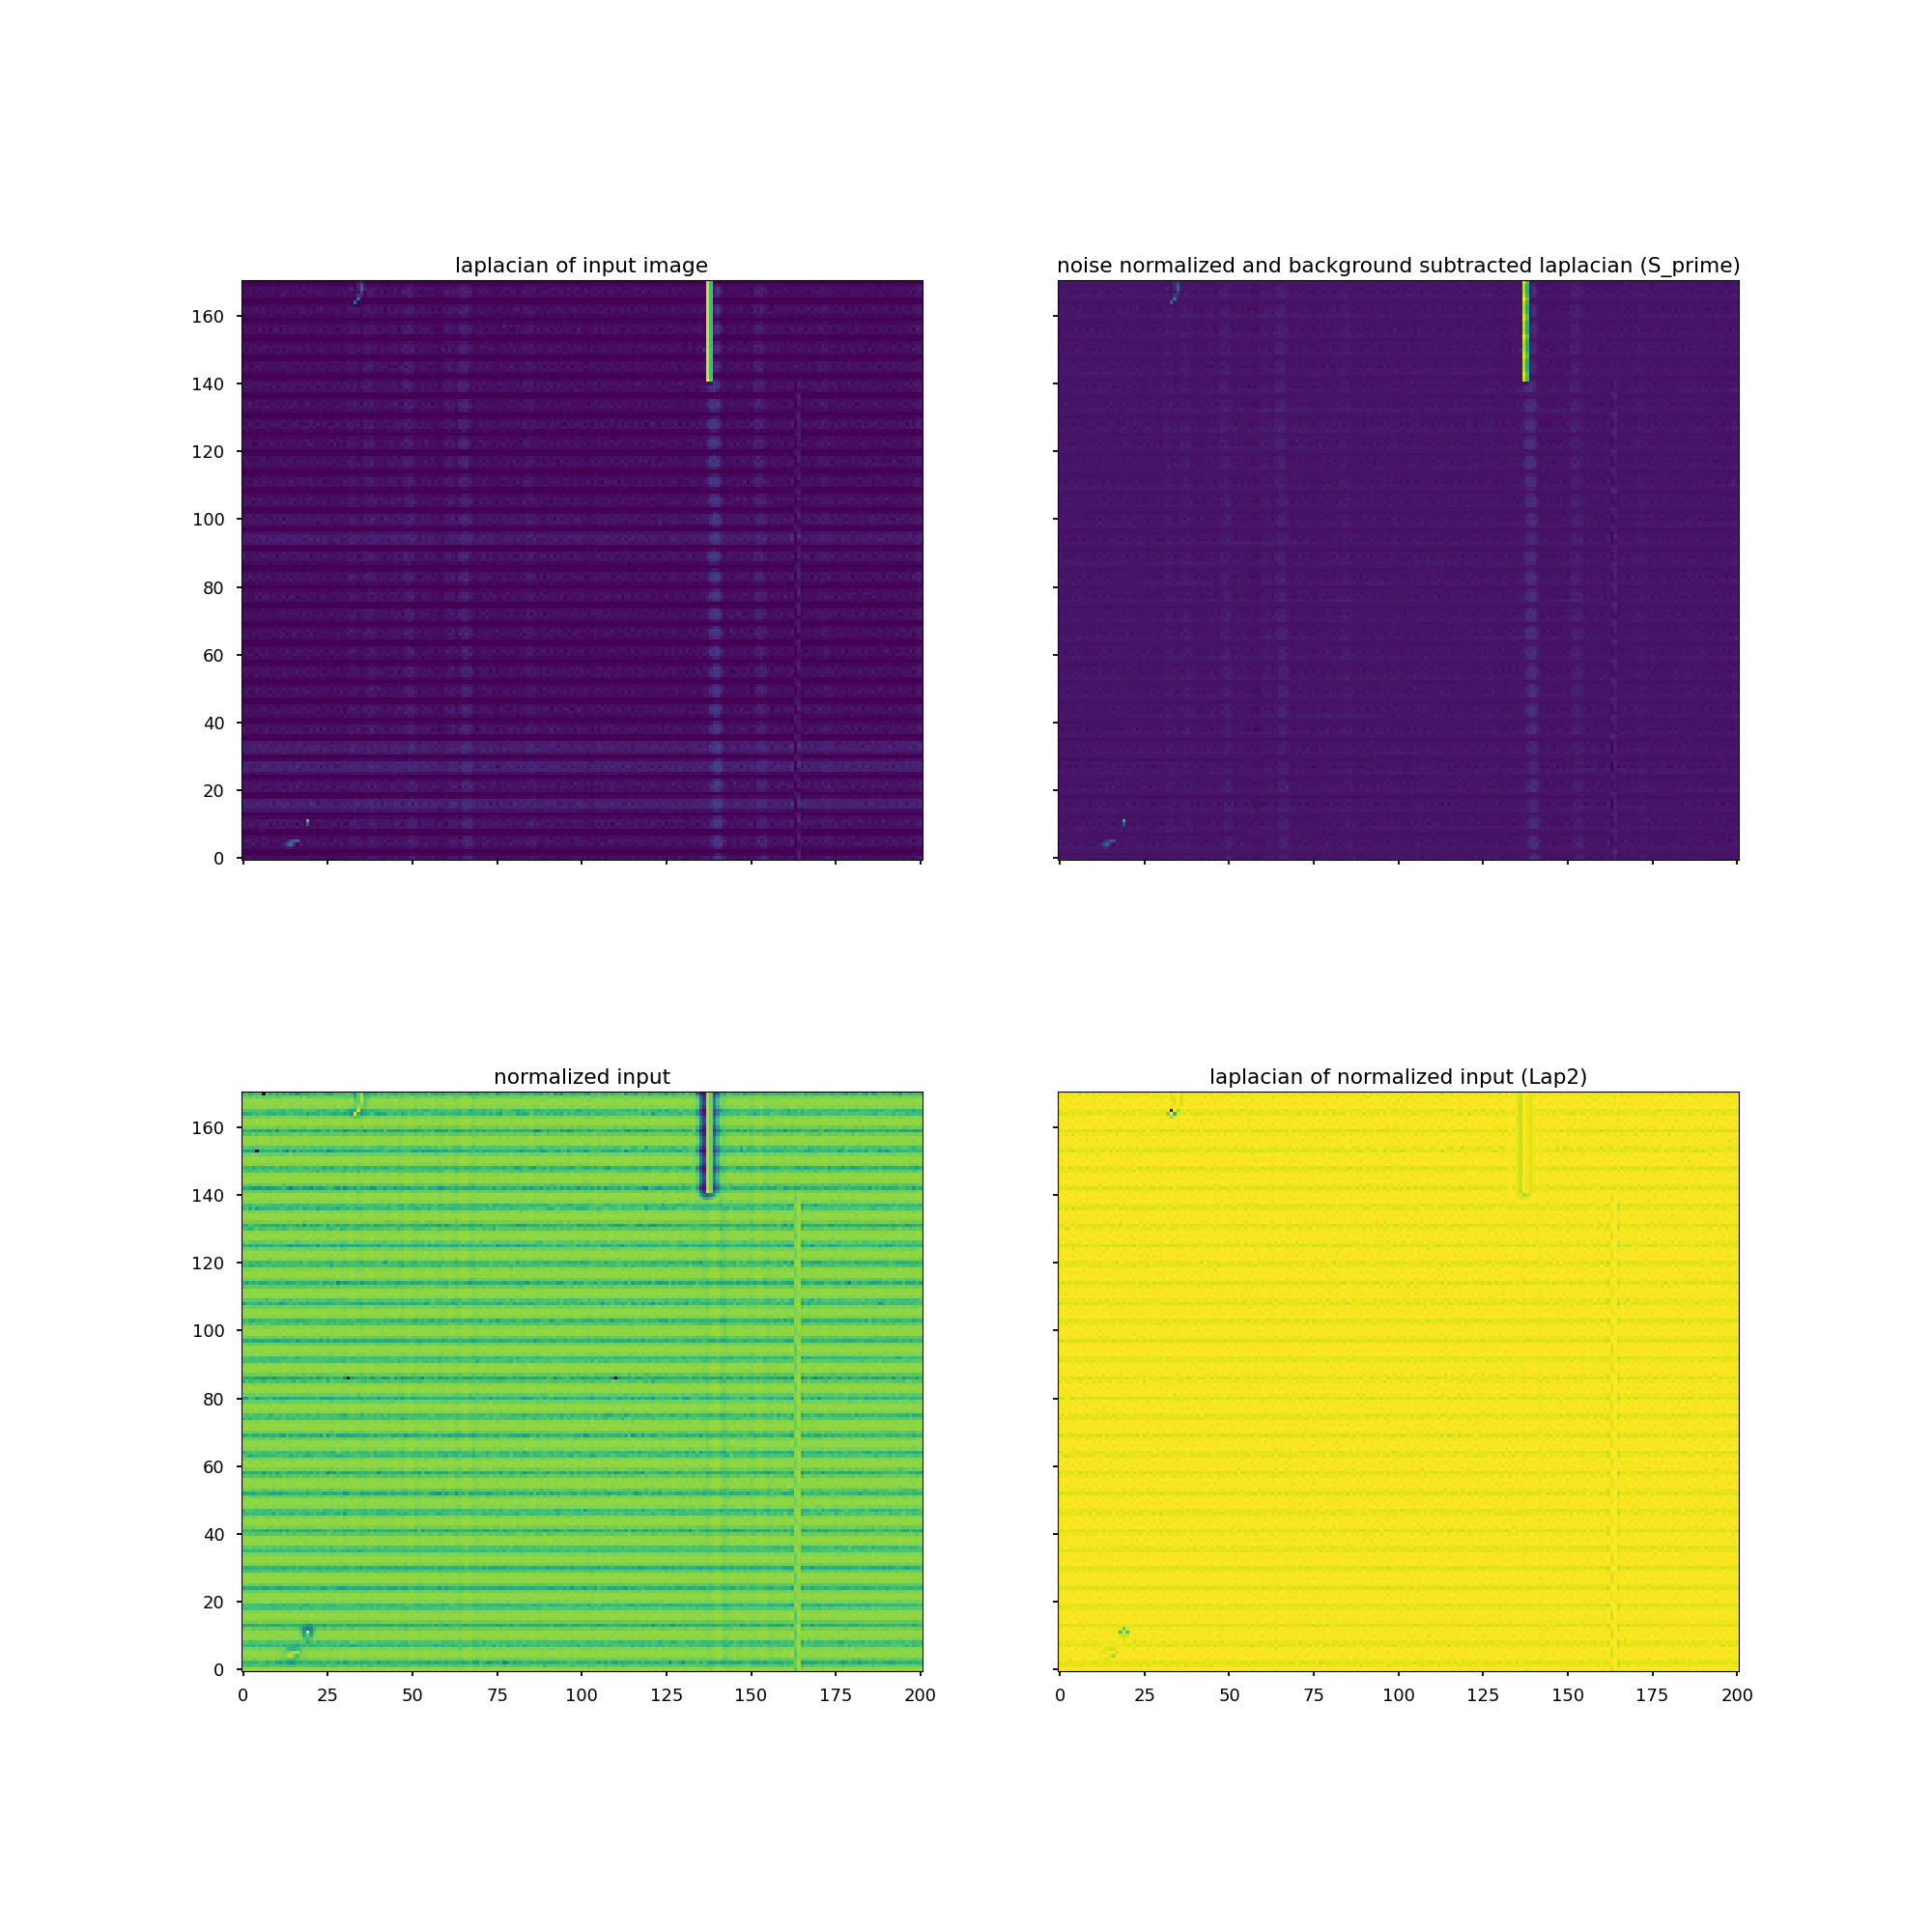

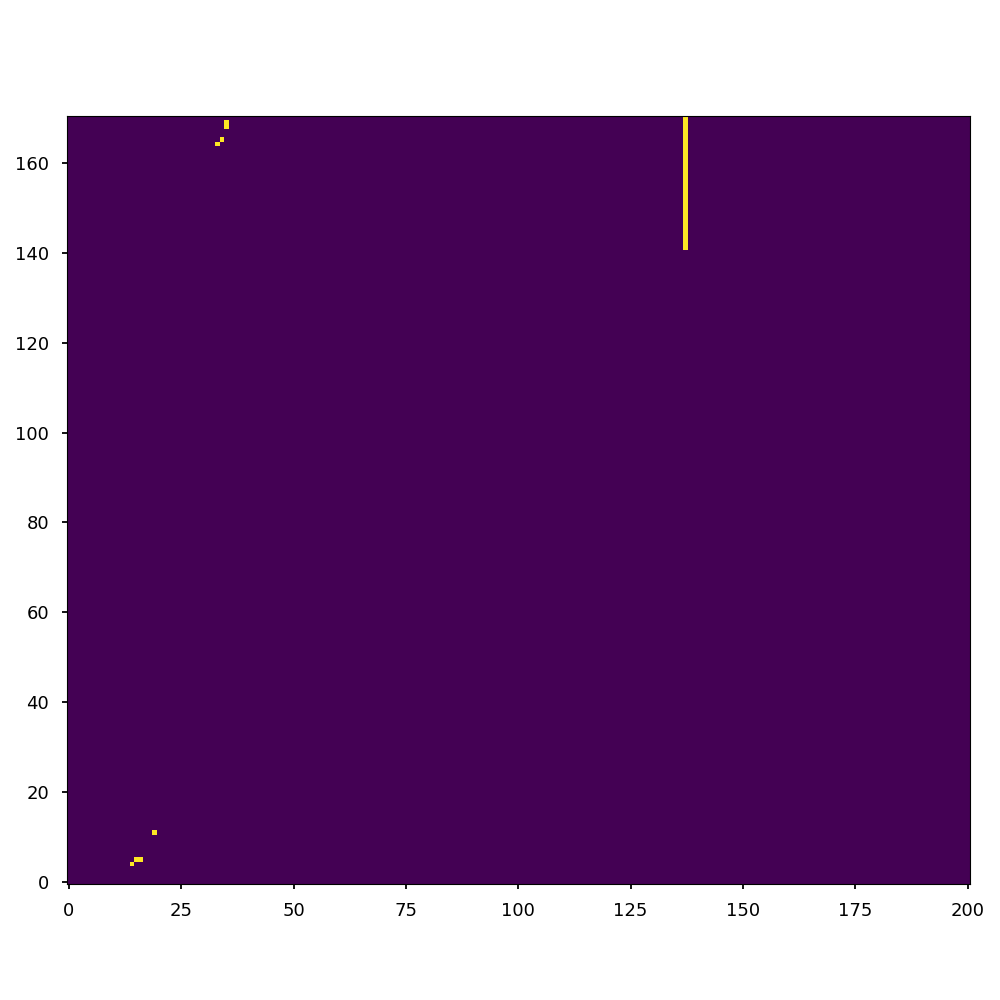

In [7]:
sub_img_copy = copy(sub_img)
cr_mask = sub_img_copy.createCosmicMask(iter=1, sigma_det=2, flim=1.1, parallel=1)

plt.figure(figsize=(10,10))
plt.imshow(cr_mask, origin="lower")
plt.tight_layout()

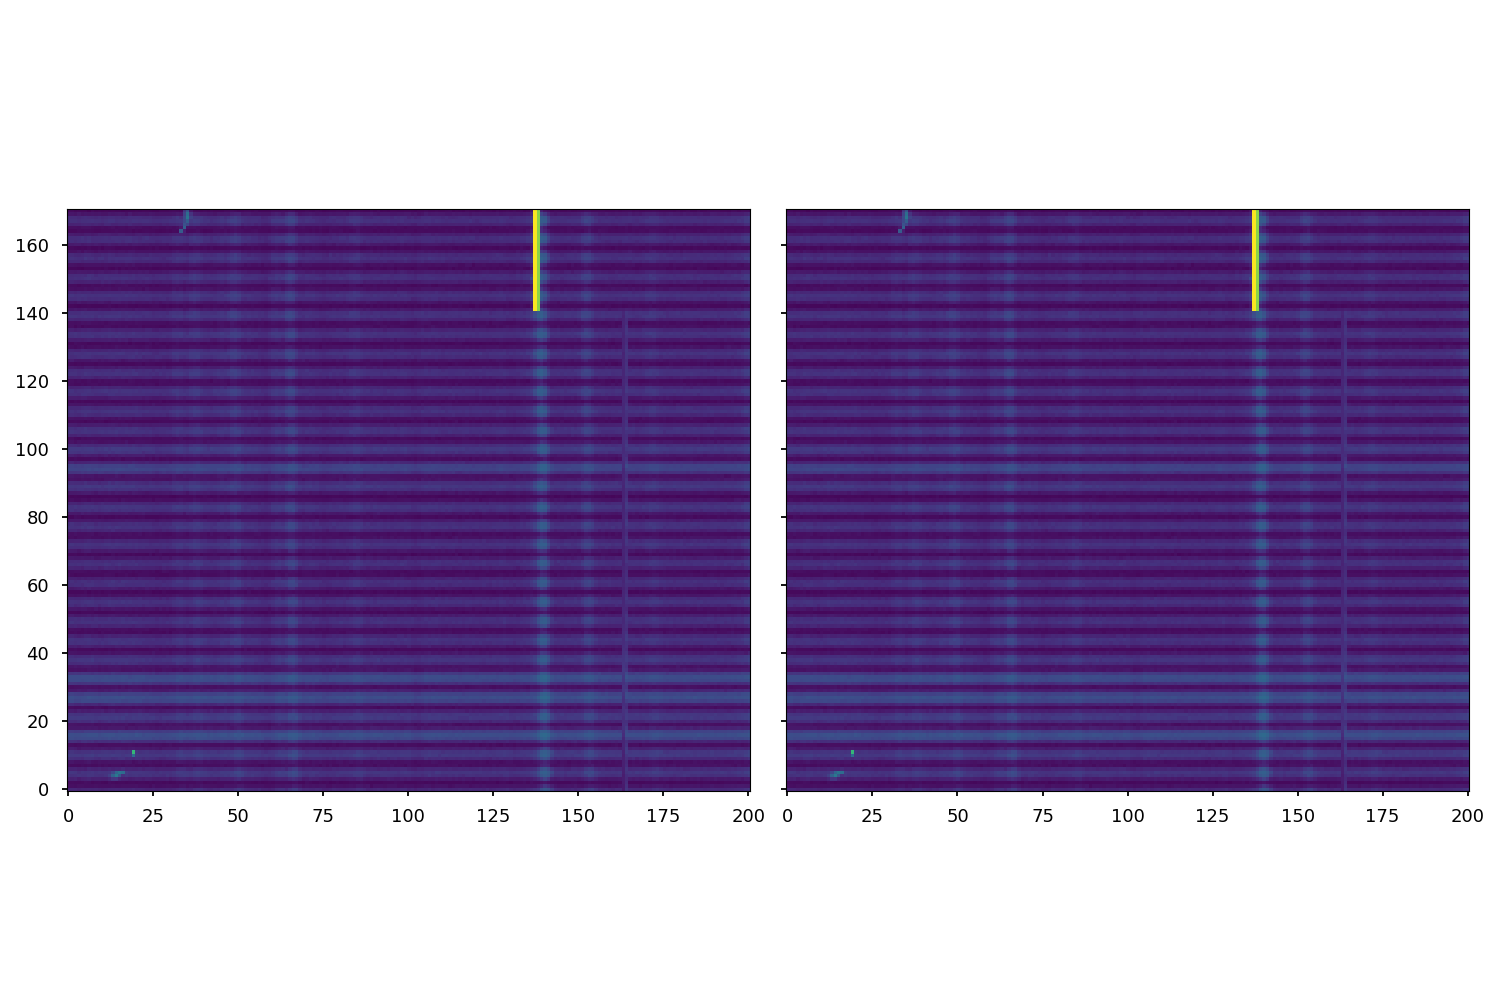

In [8]:
norm = simple_norm(img._data, stretch="log", clip=True)
fig, axs = plt.subplots(1, 2, figsize=(15,10), sharex=True, sharey=True)
axs[0].imshow(sub_img._data, origin="lower", norm=norm)
axs[1].imshow(sub_img_copy._data, origin="lower", norm=norm)
fig.tight_layout()